In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import time
import os
import pickle

from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor


import discretize 
from simpeg import maps
from simpeg.electromagnetics import time_domain as tdem
from simpeg import (
    maps,
    Data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

from simpeg.utils.solver_utils import get_default_solver

from simpeg.meta import MultiprocessingMetaSimulation #DaskMetaSimulation

In [2]:
Solver = get_default_solver()
Solver

pymatsolver.direct.pardiso.Pardiso

In [74]:
data_directory = "./synthetic-data-2d"

# set up models and mesh

In [75]:
sigma_air = 1e-8
rho_back = 500
sigma_back = 1./rho_back

In [76]:
files = [f for f in os.listdir(data_directory) if os.path.isfile(os.path.join(data_directory, f))]
files

['dpred_background.npy',
 '003-target_0-2025-06-21-12-50.npz',
 'dpred_target_0.npy',
 'dpred_target_15.npy',
 '002-target_15-2025-06-21-13-27.npz',
 '003-target_15-2025-06-21-13-27.npz',
 'true_models3d.pkl',
 '001-target_0-2025-06-21-12-50.npz',
 'log_conductivity_models_2d.pkl',
 'dpred_target_45.npy',
 'rx_times.npy',
 'mesh.json',
 '001-target_15-2025-06-21-13-27.npz',
 'dpred_target_30.npy',
 '002-target_0-2025-06-21-12-50.npz',
 'rx_locs.npy']

In [77]:
with open(f"{data_directory}/true_models3d.pkl", "rb") as f:
    true_models = pickle.load(f)

In [78]:
with open(f"{data_directory}/log_conductivity_models_2d.pkl", "rb") as f:
    log_conductivity_models_2d = pickle.load(f)

In [79]:
rx_times = np.load(f"{data_directory}/rx_times.npy")
rx_locs = np.load(f"{data_directory}/rx_locs.npy")

In [80]:
mesh = discretize.load_mesh(f"{data_directory}/mesh.json")

In [81]:
mesh

TensorMesh: 23,205 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     35     -1,365.13      1,365.13     20.00    429.88    1.55
   y     17     -1,185.13      1,185.13     20.00    429.88    1.55
   z     39     -1,110.73        940.73     10.00    333.16    1.55

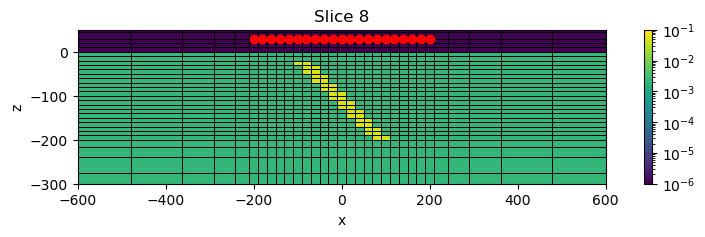

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2)) 

plt.colorbar(
    mesh.plot_slice(
        true_models["target_45"], 
        grid=True, 
        normal="y",
        pcolor_opts={"norm":LogNorm(1e-6, 1e-1)},
        grid_opts={"color":"k", "lw":0.5},
        ax=ax)[0], 
    ax=ax
)

ax.set_xlim(600*np.r_[-1, 1])
ax.set_ylim(np.r_[-300, 50])

ax.plot(rx_locs[:, 0], rx_locs[:, 2], "ro")
ax.set_aspect(1)

In [83]:
mesh_2d = discretize.TensorMesh(
    [mesh.h[0], mesh.h[2]], origin=np.r_[mesh.origin[0], mesh.origin[2]]
)


In [84]:
inds_2d_slice = (mesh.cell_centers[:, 1] < mesh.h[0].min()/2) & (mesh.cell_centers[:, 1] > -mesh.h[0].min()/2)

In [85]:
dpred_dict = {}
for key in true_models.keys(): 
    dpred_dict[key] = np.load(f"{data_directory}/dpred_{key}.npy")

In [86]:
inversion_results_dir = "./synthetic-data-2d"

In [87]:
target_0_files = [
    f for f in os.listdir(inversion_results_dir) 
    if os.path.isfile(os.path.join(inversion_results_dir, f)) 
    if "target_0" in f and "npz" in f
]

target_0_files

['003-target_0-2025-06-21-12-50.npz',
 '001-target_0-2025-06-21-12-50.npz',
 '002-target_0-2025-06-21-12-50.npz']

In [88]:
target_0_files_smoother = [f for f in target_0_files if "smoother" in f]
target_0_files = [f for f in target_0_files if "smoother" not in f]

In [89]:
# target_15_files = [
#     f for f in os.listdir(inversion_results_dir) 
#     if os.path.isfile(os.path.join(inversion_results_dir, f)) 
#     if "target_15" in f
# ]

# target_15_files

In [90]:
target_0_results = {}

for f in target_0_files: 
    key = int(f.split("-")[0])
    target_0_results[key] = np.load(f"{inversion_results_dir}/{f}", allow_pickle=True)["arr_0"].item()

In [91]:
target_0_results_smoother = {}

for f in target_0_files_smoother: 
    key = int(f.split("-")[0])
    target_0_results_smoother[key] = np.load(f, allow_pickle=True)["arr_0"].item()

In [92]:
# target_15_results = {}

# for f in target_15_files: 
#     key = int(f.split("-")[0])
#     target_15_results[key] = np.load(f, allow_pickle=True)["arr_0"].item()

In [93]:
map2d = (
    maps.ExpMap() *
    maps.InjectActiveCells(mesh_2d, active_cells=mesh_2d.cell_centers[:, 1]<0, value_inactive=np.log(1e-8))
)


In [94]:
target_0_results[1].keys()

dict_keys(['iter', 'beta', 'phi_d', 'phi_m', 'f', 'm', 'dpred'])

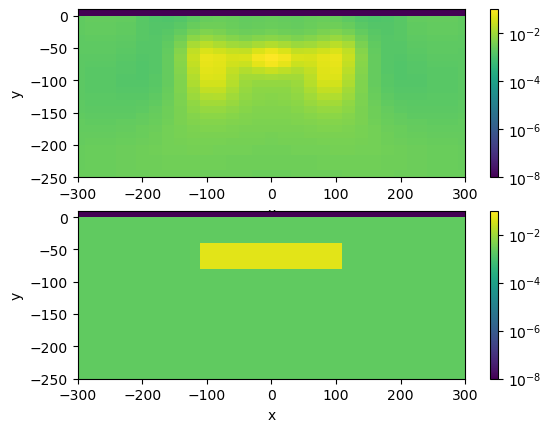

In [95]:
fig, ax = plt.subplots(2, 1)

iter_plot = 3
plt.colorbar(
    mesh_2d.plot_image(
        map2d * target_0_results[iter_plot]["m"], 
        pcolor_opts = {"norm": LogNorm(vmin=1e-8, vmax=1e-1)},
        ax=ax[0]
    )[0], ax=ax[0]
)
plt.colorbar(
    mesh_2d.plot_image(
        map2d * log_conductivity_models_2d["target_0"],
        pcolor_opts = {"norm": LogNorm(vmin=1e-8, vmax=1e-1)},
        ax=ax[1]
    )[0], ax=ax[1]
) 

for a in ax.flatten():
    a.set_xlim(np.r_[-1, 1]*300)
    a.set_ylim(np.r_[-250, 10])
    a.set_aspect(1)


In [16]:
key_invert = "target_0"

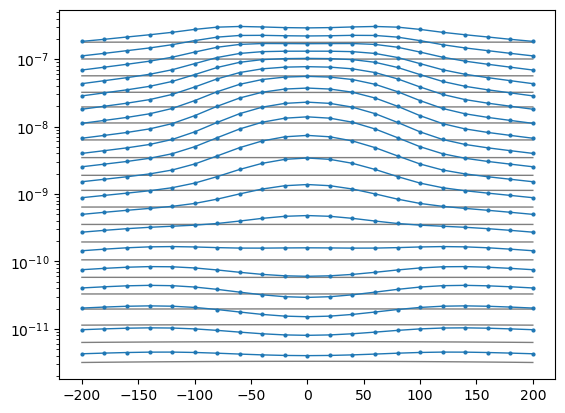

In [17]:
fig, ax = plt.subplots(1, 1) 

ax.semilogy(
    rx_locs[:, 0], -dpred_dict["background"].reshape(rx_locs.shape[0], len(rx_times)), color="k", lw=1, alpha=0.5
);
ax.semilogy(
    rx_locs[: ,0], -dpred_dict[key_invert].reshape(rx_locs.shape[0], len(rx_times)), "C0-o", lw=1, ms=2
);


In [18]:
ind = 10
rx_locs[ind, :]

array([ 0.,  0., 30.])

In [19]:
rel_error=0.05
noise_floor=1e-12

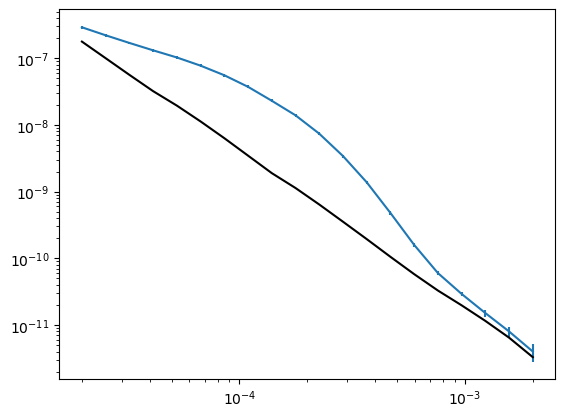

In [20]:

fig, ax = plt.subplots(1, 1) 

data_plot = -dpred_dict[key_invert].reshape(rx_locs.shape[0], len(rx_times))[ind, :]
ax.errorbar(rx_times, data_plot, yerr=np.abs(data_plot)*rel_error + noise_floor)

ax.loglog(
    rx_times, -dpred_dict["background"].reshape(rx_locs.shape[0], len(rx_times))[ind, :], color="k"
)



In [21]:
sim = get_sim(mesh, mesh_2d)

In [22]:
# set up 3D inversion 
def create_inversion(key_invert, mesh=mesh, mesh_2d=mesh_2d): 
    relative_error=0.05
    noise_floor=1e-12
    # alpha_s = 1e-1
    # alpha_x = 1
    rho_back = 500
    # beta0 = 10

    dobs = dpred_dict[key_invert]
    sim = get_sim(mesh, mesh_2d)
    data_invert = Data(
        dobs=dobs, survey=sim.survey, standard_deviation=np.abs(dobs)*relative_error + noise_floor
    )
    
    dmis = data_misfit.L2DataMisfit(simulation=sim, data=data_invert)
    reg = regularization.WeightedLeastSquares(
        mesh_2d, 
        active_cells=sim.sigmaMap.maps[2].active_cells,
        # alpha_s=1e-6, 
        # alpha_x=alpha_x, 
        reference_model=np.log(1./rho_back),
        # norms=norms
    )
    
    opt = optimization.InexactGaussNewton(maxIter=10, maxIterCG=30, tolCG=1e-3)
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)
    
    # Defining a starting value for the trade-off parameter (beta) between the data
    # misfit and the regularization.
    starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)
    
    cool_beta = directives.BetaSchedule(coolingFactor=1.5, coolingRate=1)
    
    # Update the preconditionner
    # update_Jacobi = directives.UpdatePreconditioner()
    
    # Options for outputting recovered models and predicted data for each beta.
    save_iteration = directives.SaveOutputDictEveryIteration(
        saveOnDisk=True, name=f"{key_invert}"
    )
    
    
    # Updating the preconditionner if it is model dependent.
    # update_jacobi = directives.UpdatePreconditioner()
    
    # Add sensitivity weights
    # sensitivity_weights = directives.UpdateSensitivityWeights()
    
    target_misfit = directives.TargetMisfit()
    
    # The directives are defined as a list.
    directives_list = [
        # sensitivity_weights,
        # update_jacobi,
        starting_beta,
        cool_beta,
        save_iteration,
        target_misfit,
    ]
    
    # Here we combine the inverse problem and the set of directives
    inv = inversion.BaseInversion(inv_prob, directives_list)
    return inv

In [23]:
inv = create_inversion("target_0")

In [24]:
m0 = np.log(1./rho_back) * np.ones((mesh_2d.cell_centers[:, 1] < 0).sum())

In [25]:
len(m0)

980

In [ ]:
%%time
inv.run(m0)


Running inversion with SimPEG v0.24.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DElectricField problem***
                        


/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/pymatsolver/direct/pardiso.py:49: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format.
  self.solver = MKLPardisoSolver(
/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


simpeg.SaveOutputDictEveryIteration will save your inversion progress as dictionary: '###-target_0-2025-06-21-12-50.npz'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
